In [8]:
########################################################################
##### Requirements
#####  Python3, keras, cv2, imutils
########################################################################

### Initialize

In [25]:
from keras.preprocessing.image import img_to_array
from imutils.perspective import four_point_transform
import cv2,math,imutils
import numpy as np
from matplotlib import pyplot as plt
import sys
from keras.models import load_model
from imutils import contours
import imutils
import cv2
%matplotlib inline

def preprocess(image, width, height):
	(h, w) = image.shape[:2]
	if w > h:
		image = imutils.resize(image, width=width)
	else:
		image = imutils.resize(image, height=height)
	padW = int((width - image.shape[1]) / 2.0)
	padH = int((height - image.shape[0]) / 2.0)
	image = cv2.copyMakeBorder(image, padH, padH, padW, padW,cv2.BORDER_REPLICATE)
	image = cv2.resize(image, (width, height), interpolation = cv2.INTER_CUBIC)
	return image

def auto_canny(image , sigma = 0.33):
    v = np.median(image)
    lower = int(max(0,(1.0- sigma)  * v))
    upper = int(min(255 , (1.0 + sigma) * v))
    return lower , upper 

def plot(img,title=""):
    plt.title(title)
    plt.imshow(img,cmap='gray')
    plt.show()

def get_transformed_imgs(fpath):
    o_img = cv2.imread(fpath)
    o_img = cv2.GaussianBlur(o_img, (5,5), 10)
    o_img = cv2.cvtColor(o_img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(o_img, (512,512))
    plot(img,"Orig Img, Resized 512x512")
    edged = cv2.Canny(img, 10, 250)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
    dilated = cv2.dilate(edged,kernel,iterations = 1)
    dilated=cv2.bitwise_not(dilated)
    #plot(dilated,"ProcessedImage,512x512")
    thresh = cv2.threshold(dilated,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    #plot(thresh)
    return dilated,thresh

def identify_contour_and_predict(dilated,thresh,bg,debug=False):
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:]
    cnts = contours.sort_contours(cnts)[0]
    output = cv2.merge([dilated] * 3)
    for i,c in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)    
        roi = dilated[y - 3:y + h + 3, x - 3:x + w + 3]
        roi = preprocess(roi, 28, 28)
        if bg=="BLACK":
            roi=cv2.bitwise_not(roi)
        if(debug):
            plot(roi,'IdentifiedLetter')
        roi = np.expand_dims(img_to_array(roi), axis=0)
        pred = model.predict(roi).argmax(axis=1)[0] # ADD +1 for 9 class case
        if(debug):
            print("Model Predicted Digit : "+str(pred))
        predictions.append(str(pred))
        cv2.rectangle(output, (x - 2, y - 2),(x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, str(pred), (x - 5, y - 5),cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)

        cv2.rectangle(output,(x-2,y-2),(x + w+4, y + h+4), (0, 255, 0), 1)
    plot(output,"Labeled Image")

### Load MNIST Trained Model

In [26]:
# CNN model on mnsit dataset
model = load_model("../resources/models/mnist/cnn.model")

# Lenet model
# model = load_model("../resources/models/mnist/lenet.hdf5")

### Identify Letters & Predict Digit

Processing File : eq12.jpg


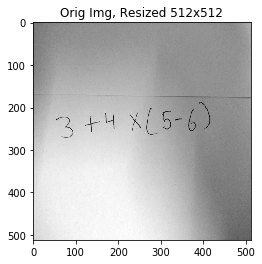

Failed Processing : eq12.jpg


In [28]:
from glob import glob
for fpath in glob("../resources/datasets/digitsPictures/*"):
    print("Processing File : "+fpath.split("/")[-1])
    try:
        dilated,thresh=get_transformed_imgs(fpath)
        identify_contour_and_predict(dilated,thresh,bg="BLACK",debug=False)
    except:
        print("Failed Processing : "+fpath.split("/")[-1])
        pass

### Miscelleneous

In [29]:
#img = cv2.copyMakeBorder(img, 20, 20, 20, 20,cv2.BORDER_REPLICATE)
#closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
#closed=cv2.bitwise_not(closed)
#plot(dilated)
#plot(closed)
def resize_w_aspectratio(img,size):
    TARGET_PIXEL_AREA = size*size
    ratio = float(img.shape[1]) / float(img.shape[0])
    new_h = int(math.sqrt(TARGET_PIXEL_AREA / ratio) + 0.5)
    new_w = int((new_h * ratio) + 0.5)
    image = cv2.resize(img, (new_w,new_h))
    return image

def morphblackhat(image):
    image=cv2.GaussianBlur(image, (3, 3), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(25,25))
    image = cv2.morphologyEx(image,cv2.MORPH_BLACKHAT,kernel)
    image = cv2.bitwise_not(image)
    #sharpen image
    #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    #image=cv2.filter2D(image, -1, kernel)
    return image
def adjust_gamma(image, gamma=1.0):
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	return cv2.LUT(image, table)